In [ ]:
!pip install tb

In [ ]:
!pip install attrdict

In [ ]:
!pip install d3rlpy

In [3]:
import os
import re

import torch
import numpy as np
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import datasets
from torchvision import transforms
from torch import nn
from torch.nn import functional as F
import random
import torchvision.utils as vutils
import argparse
import math
import cv2
from matplotlib import pyplot as plt

from torchsummary import summary

from abc import abstractmethod

# Set random seed for reproducibility
seed = 1141
# seed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", seed)
random.seed(seed)
torch.manual_seed(seed)
device = torch.device("cuda:8" if (torch.cuda.is_available()) else "cpu")

Random Seed:  1141


In [31]:
train_ds = EdgesDataset(config=config)

dataloader = DataLoader(train_ds, config.parameters.dreamer.batch_size, shuffle=False)

In [41]:
train_ds[0]

(tensor([[[0., 1., 0.,  ..., 0., 0., 0.],
          [0., 1., 1.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[1., 0., 1.,  ..., 0., 0., 0.],
          [1., 1., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 tensor([[[0., 1., 0.,  ..., 0., 0., 0.],
          [0., 1., 0.,  ..., 0., 0., 0.],
          [0., 1., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 1.,  ..., 0., 0., 0.],
          [0., 0., 1.,  ..., 0., 0., 0.],
          [0., 0., 1.,  ..., 1., 1., 1.]],
 
         [[0., 1., 0.,  ..., 0., 0., 0.],
          [0., 1., 0.,  ..., 0., 0., 0.],
          [0., 1., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 1.,  ..., 1., 1., 1.],
       

In [2]:
from encoder import Encoder

In [3]:
model = Encoder(config)

In [6]:
model.to('cuda')

Encoder(
  (_convs): Sequential(
    (0): Conv2dSame(2, 8, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2dSame(8, 16, kernel_size=(3, 3), stride=(2, 2))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2dSame(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2dSame(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
  )
)

In [2]:
from decoder import Decoder

In [3]:
model = Decoder(config)

In [4]:
model.to('cuda')

Decoder(
  (_conv_transes): Sequential(
    (0): ConvTranspose2dSame(64, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): ConvTranspose2dSame(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): ConvTranspose2dSame(16, 8, kernel_size=(3, 3), stride=(2, 2))
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): ConvTranspose2dSame(8, 2, kernel_size=(3, 3), stride=(2, 2))
    (10): Sigmoid()
  )
)

In [1]:
from vae import EdgeEntropyVAE

In [3]:
model = EdgeEntropyVAE(config, 0.5)

In [4]:
model

EdgeEntropyVAE(
  (encoder): Encoder(
    (_convs): Sequential(
      (0): Conv2dSame(2, 8, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Conv2dSame(8, 16, kernel_size=(3, 3), stride=(2, 2))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Conv2dSame(16, 32, kernel_size=(3, 3), stride=(2, 2))
      (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): LeakyReLU(negative_slope=0.01)
      (9): Conv2dSame(32, 64, kernel_size=(3, 3), stride=(2, 2))
      (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): LeakyReLU(negative_slope=0.01)
    )
  )
  (decoder): Decoder(
    (_conv_transes): Sequential(
      (0): ConvTranspose2dSame(64, 32, kernel_size=(3, 3), stride=(2, 2))
      (

In [10]:
model.reparameterize(torch.Tensor([0]), torch.Tensor([2]))

tensor([-0.3455])

In [15]:
torch.stack([torch.Tensor([[[0,1],[0,1]]]),torch.Tensor([[[1,1],[1,1]]])]).shape

torch.Size([2, 1, 2, 2])

In [54]:
import re
import cv2

def extract_metadata(fpath):
    
    with open(fpath, 'r') as file:
        info = file.read().rstrip()
        
    info_splited = info.split('_')
    
    timestep = int(info_splited[0])
    reward = int(info_splited[1])
    player_x = int(info_splited[2])
    player_y = int(info_splited[3])
    
    
    movements = info_splited[4].split(';')[:-1]
    
    walk_distance = jump_height = jump_true = 0
    
    for i in range(len(movements)):
        
        movement_list = [int(x) for x in list(movements[i])]
        
        if movement_list[0] == 1:
            walk_distance -= 1
            
        if movement_list[1] == 1:
            walk_distance += 1
        
        if movement_list[2] == 1:
            jump_true = 1
        
        # Если jumpt_true == 0, то не делаем ничего
        if (movement_list[3] == 0) and (jump_true == 1):
            jump_height += 1
        elif (movement_list[3] == 1) and (jump_true == 1):
            jump_height += 1
            jump_true = 0
    
    return timestep, reward, player_x, player_y, walk_distance, jump_height

def load_img(seed, timestep, config):
    
    image_path_1 = config.parameters.edges_dataset.data_root + f'/screenshots0000_{seed}/{timestep}.png'
    image_path_2 = re.sub(r'/screenshots/', r'/screenshots_add/', image_path_1)

    metadata_path = image_path_2[:-3] + 'txt'

    timestep, reward, player_x, player_y, walk_distance, jump_height = extract_metadata(metadata_path)

    if timestep < 7668:
        timestep_next = timestep + 6
        terminal = False
    else:
        terminal = True

    # do your magic here
    # флаг 0 = читаем черно-белое изображение
    img1 = cv2.imread(image_path_1, 0)
    img2 = cv2.imread(image_path_2, 0)

    img_full1 = transform_img(img1, dim=[self.config.image_size, self.config.image_size], zero_screenshot=self.zero_screenshot, aperture_size=self.config.aperture_size)
    img_full2 = transform_img(img2, dim=[self.config.image_size, self.config.image_size], zero_screenshot=self.zero_screenshot, aperture_size=self.config.aperture_size)

    img_part1 = transform_img(img1, dim=[self.config.image_size, self.config.image_size], zero_screenshot=self.zero_screenshot_part, part_size=self.config.part_size, player_x=player_x, player_y=player_y, aperture_size=self.config.aperture_size)
    img_part2 = transform_img(img2, dim=[self.config.image_size, self.config.image_size], zero_screenshot=self.zero_screenshot_part, part_size=self.config.part_size, player_x=player_x, player_y=player_y, aperture_size=self.config.aperture_size)

    sample_full = cv2.merge([img_full1, img_full2])
    sample_part = cv2.merge([img_part1, img_part2])
    
    return transforms.ToTensor()(sample_full), transforms.ToTensor()(sample_part), timestep, (player_x, player_y), (walk_distance, jump_height), reward, terminal

In [55]:
load_img(359803652, 12, config)

NameError: name 'transform_img' is not defined

In [3]:
train_ds = EdgesDataset(config=config)

dataloader = DataLoader(train_ds, config.parameters.dreamer.batch_size, shuffle=False)

In [4]:
seeds = get_seed_list(config.parameters.edges_dataset.data_root)

In [6]:
observations, actions, rewards, terminals = train_ds.load_episodes(seeds)

In [7]:
print(observations.shape, actions.shape, rewards.shape, terminals.shape)

(12770, 4, 64, 64) (12770, 2) (12770,) (12770,)


In [8]:
from d3rlpy.dataset import MDPDataset

dataset = MDPDataset(observations, actions, rewards, terminals, discrete_action=False)

In [16]:
dataset.dump('MDPdataset_SMF_' + datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))

In [13]:
encoder = Encoder(config).to(device)

In [15]:
observation = buffer.sample(10,10)['observation']
torch.cat([encoder(observation[:,:,0,:,:]),encoder(observation[:,:,1,:,:]),encoder(observation[:,:,2,:,:]),encoder(observation[:,:,3,:,:])],-1)

tensor([[[ 2.3416e-01,  6.0045e-01,  1.3020e+00,  ...,  1.1233e-01,
           1.1233e-01, -8.3058e-04],
         [ 3.3554e-01,  9.1756e-01,  6.0683e-01,  ..., -5.1583e-04,
          -5.1583e-04,  1.5307e-01],
         [-1.5669e-03,  1.1114e+00,  5.8742e-01,  ...,  1.2243e+00,
           2.1191e-01,  2.8043e+00],
         ...,
         [-5.0152e-03,  1.6649e+00,  5.2799e-01,  ..., -6.6693e-03,
          -6.6693e-03, -5.2427e-03],
         [ 3.0595e-01,  1.8360e+00, -1.6966e-03,  ...,  1.9619e+00,
           1.6654e+00,  1.0970e+00],
         [-7.8754e-03,  1.2732e+00, -4.6416e-03,  ..., -2.4606e-02,
          -4.2104e-04, -3.7070e-03]],

        [[ 1.9091e+00,  1.2435e-01,  2.9624e+00,  ...,  1.3341e+00,
          -1.0054e-03,  4.9796e-01],
         [ 1.9683e+00,  8.7909e-01,  4.6802e-01,  ...,  2.9038e+00,
           4.3718e-01,  1.3804e+00],
         [ 1.4281e-01,  7.9280e-01,  2.2420e-01,  ...,  1.7712e+00,
           3.2704e+00,  1.3540e+00],
         ...,
         [-3.9153e-03,  3

In [21]:
encoder(buffer.sample(10,10)['observation'][:,:,3,:,:]).shape

torch.Size([10, 10, 1024])

In [1]:
config_file='config.yml'

import importlib

from dataset import EdgesDataset, get_seed_list
from utils import load_config
from torch.utils.data import DataLoader
import torch
import numpy as np

from datetime import datetime
from torch.utils.tensorboard import SummaryWriter

config = load_config(config_file)

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from d3rlpy.dataset import MDPDataset

dataset = MDPDataset.load('MDPdataset_SMF_2023-03-24_13-47-05')

In [3]:
observation_shape = dataset.get_observation_shape()
action_size =  dataset.get_action_size()

In [4]:
from buffer import ReplayBuffer

In [5]:
buffer = ReplayBuffer(observation_shape, action_size, config)

In [6]:
for episode in dataset.episodes:
    for transition in episode.transitions:
        buffer.add(transition.observation, transition.action, transition.reward, transition.next_observation, transition.terminal)

In [7]:
buffer.buffer_index

12770

In [8]:
import encoder
importlib.reload(encoder)
from encoder import Encoder

In [9]:
import decoder
importlib.reload(decoder)
from decoder import Decoder

In [10]:
import dreamer
importlib.reload(dreamer)
from dreamer import Dreamer

In [11]:
log_dir = (
        "runs/"
        + datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        + "_"
        + config.operation.log_dir
    )
writer = SummaryWriter(log_dir)
device = config.operation.device
obs_shape = dataset.get_observation_shape()
discrete_action_bool = False 
action_size = dataset.get_action_size()

agent = Dreamer(
            obs_shape, discrete_action_bool, action_size, writer, device, config, verbose=False
        )

In [30]:
agent.train_offline(buffer)

0.6708557605743408 1.0767464637756348 7.568482208251954
0.6671469211578369 1.0628635883331299 7.303677368164063
0.6373562812805176 1.0573259592056274 6.0257415771484375
0.6383171081542969 1.0433728694915771 5.258539962768555
0.6468037366867065 1.024618148803711 4.965301513671875
0.6274429559707642 1.00757896900177 4.403706741333008
0.6145423650741577 0.9890864491462708 3.8103111267089846
0.6103948950767517 0.9742968678474426 3.3273593902587892
0.597464919090271 0.9615891575813293 2.9329298019409182
0.6085523366928101 0.9478663206100464 2.6573686599731445
0.5999749898910522 0.9313552379608154 2.329964256286621
0.5776132941246033 0.9154664874076843 2.026239776611328
0.5759062170982361 0.8995018005371094 1.7966642379760742
0.5637679100036621 0.8869664669036865 1.563286590576172
0.5566348433494568 0.8742443919181824 1.396844482421875
0.5609045624732971 0.8613051772117615 1.256697177886963
0.5698003172874451 0.8504969477653503 1.1138050079345703
0.5540505647659302 0.8413512110710144 0.98746

0.38079896569252014 0.5049310922622681 0.30000000000000004
0.3746107518672943 0.5043424963951111 0.30000000000000004
0.38269343972206116 0.5041232109069824 0.30000000000000004
0.35677847266197205 0.502157986164093 0.30000000000000004
0.345584511756897 0.5012481212615967 0.30000000000000004
0.3497719466686249 0.500217616558075 0.33633987903594975
0.36806419491767883 0.49603894352912903 0.30000000000000004
0.34978991746902466 0.49751269817352295 0.30000000000000004
0.3534627854824066 0.4954647123813629 0.30000000000000004
0.3594590425491333 0.4967246353626251 0.30000000000000004
0.3500423729419708 0.49475130438804626 0.30000000000000004
0.36078494787216187 0.4933125376701355 0.3285868644714356
0.3626626431941986 0.49347612261772156 0.30000000000000004
0.3513617217540741 0.4930892586708069 0.30000000000000004
0.36603060364723206 0.49143660068511963 0.30000000000000004
0.36336106061935425 0.487827330827713 0.30000000000000004
0.3607749342918396 0.4904356896877289 0.30000000000000004
0.3507

0.32437261939048767 0.39485636353492737 0.3058928012847901
0.32609736919403076 0.3833819627761841 0.30000000000000004
0.3604942262172699 0.39623576402664185 0.30000000000000004
0.2952330410480499 0.3872116506099701 0.30000000000000004
0.31711381673812866 0.3870617747306824 0.30000000000000004
0.3156186640262604 0.38279426097869873 0.30000000000000004
0.31063055992126465 0.3851679563522339 0.30000000000000004
0.31850796937942505 0.3836749196052551 0.30000000000000004
0.32211369276046753 0.3815195858478546 0.32343502044677735
0.3072780668735504 0.38225218653678894 0.30000000000000004
0.3477497398853302 0.3856247067451477 0.30000000000000004
0.3091481626033783 0.38472864031791687 0.30000000000000004
0.2966761291027069 0.37408646941185 0.30000000000000004
0.3463386595249176 0.37766170501708984 0.3607720136642456
0.3062940239906311 0.38143694400787354 0.30000000000000004
0.34714558720588684 0.3816046416759491 0.30000000000000004
0.3449816405773163 0.3836258053779602 0.30000000000000004
0.31

0.31486406922340393 0.2744560241699219 0.30000000000000004
0.33092719316482544 0.28042131662368774 0.30000000000000004
0.2884427309036255 0.2671315670013428 0.30000000000000004
0.3164921998977661 0.2664755880832672 0.30000000000000004
0.28585371375083923 0.26790136098861694 0.30000000000000004
0.279744029045105 0.2695551812648773 0.30000000000000004
0.3138064444065094 0.2768060564994812 0.30516741275787357
0.3418158292770386 0.2716677486896515 0.30000000000000004
0.30676010251045227 0.26323604583740234 0.30000000000000004
0.3429783284664154 0.2701653838157654 0.30000000000000004
0.3370521664619446 0.27432554960250854 0.30000000000000004
0.29601895809173584 0.2656458914279938 0.31914160251617435
0.3288158178329468 0.2649717628955841 0.30000000000000004
0.3266424536705017 0.2722932696342468 0.30000000000000004
0.3461208939552307 0.27482888102531433 0.30000000000000004
0.3218769133090973 0.2604038417339325 0.30000000000000004
0.2842610776424408 0.2634238600730896 0.30000000000000004
0.307

0.32627367973327637 0.2300398200750351 0.30000000000000004
0.291543185710907 0.2336893528699875 0.30000000000000004
0.2714768648147583 0.22650790214538574 0.30000000000000004
0.29183438420295715 0.23008960485458374 0.30000000000000004
0.33992889523506165 0.2322293072938919 0.30000000000000004
0.3014897108078003 0.22437457740306854 0.3363553524017334
0.3167852759361267 0.2352025806903839 0.30000000000000004
0.29175981879234314 0.22959429025650024 0.30000000000000004
0.31049978733062744 0.22371652722358704 0.30000000000000004
0.30400335788726807 0.21843348443508148 0.30000000000000004
0.28844836354255676 0.23168803751468658 0.30000000000000004
0.3258739411830902 0.2362595498561859 0.30000000000000004
0.2934175133705139 0.22839990258216858 0.30000000000000004
0.29606175422668457 0.22942037880420685 0.30000000000000004
0.3223850727081299 0.2452419251203537 0.36342916488647464
0.2926119863986969 0.22817924618721008 0.30000000000000004
0.2922148108482361 0.2252119928598404 0.3000000000000000

0.29279887676239014 0.22222590446472168 0.31497447490692143
0.28584927320480347 0.21876174211502075 0.30000000000000004
0.26691901683807373 0.21123597025871277 0.30000000000000004
0.2831036150455475 0.21337160468101501 0.30000000000000004
0.33528825640678406 0.2148541510105133 0.30000000000000004
0.30494752526283264 0.20780318975448608 0.30000000000000004
0.3466346859931946 0.22120727598667145 0.30000000000000004
0.3017483353614807 0.21464622020721436 0.30000000000000004
0.3006114661693573 0.21856772899627686 0.3049139499664307
0.30427634716033936 0.21890145540237427 0.30000000000000004
0.3388828933238983 0.22457633912563324 0.30000000000000004
0.3161056339740753 0.2145061194896698 0.30000000000000004
0.30471062660217285 0.20946666598320007 0.30000000000000004
0.3107038140296936 0.2187507301568985 0.30000000000000004
0.29851651191711426 0.21777194738388062 0.30000000000000004
0.3217230439186096 0.21588286757469177 0.30000000000000004
0.3364129662513733 0.20554699003696442 0.30000000000

0.3112685978412628 0.1957094967365265 0.33632323741912845


KeyboardInterrupt: 

In [14]:
agent.save_params('test')

In [12]:
agent.load_params('test')

In [13]:
agent.trajectories_rollout(buffer)

0.40916115045547485 0.4451330602169037 0.6000000000000001


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 1100 but got size 1125 for tensor number 1 in the list.

In [54]:
import encoder
importlib.reload(encoder)
from encoder import Encoder
encoder = Encoder(config)
encoder(torch.Tensor(dataset.observations[:10])).shape

torch.Size([10, 4, 1024])

In [28]:
decoder_debug = Decoder(observation_shape, config).to(device)

In [13]:
agent.posteriors_debug.shape, agent.determenistics_debug.shape

(torch.Size([25, 44, 70]), torch.Size([25, 44, 200]))

In [30]:
import matplotlib.pyplot as plt

def show_images(sample):
    fig = plt.figure(figsize=(25, 16))
    for i in np.arange(1,32):

        ax = fig.add_subplot(4, 8, i, xticks=[], yticks=[])
        plt.imshow(sample[i])


In [82]:
sample = buffer.sample(
                    35, 44
                )
sample['action'].reshape(-1, 2).shape

torch.Size([1540, 2])

In [87]:
torch.save(agent.state_dict(), 'agent_test.pth')

AttributeError: 'Dreamer' object has no attribute 'state_dict'

In [86]:
agent.dynamic_learning_infos.get_stacked()

AttrDict({})

In [31]:
sample = buffer.sample(
                    35, 44
                )['observation'][:,:,0]
sample.shape

torch.Size([35, 44, 64, 64])

In [32]:
reconstructed_samples_part = agent.decoder_part(agent.posteriors_debug, agent.determenistics_debug).detach().cpu()
reconstructed_samples_full = agent.decoder_full(agent.posteriors_debug, agent.determenistics_debug).detach().cpu()

In [69]:
n = 13

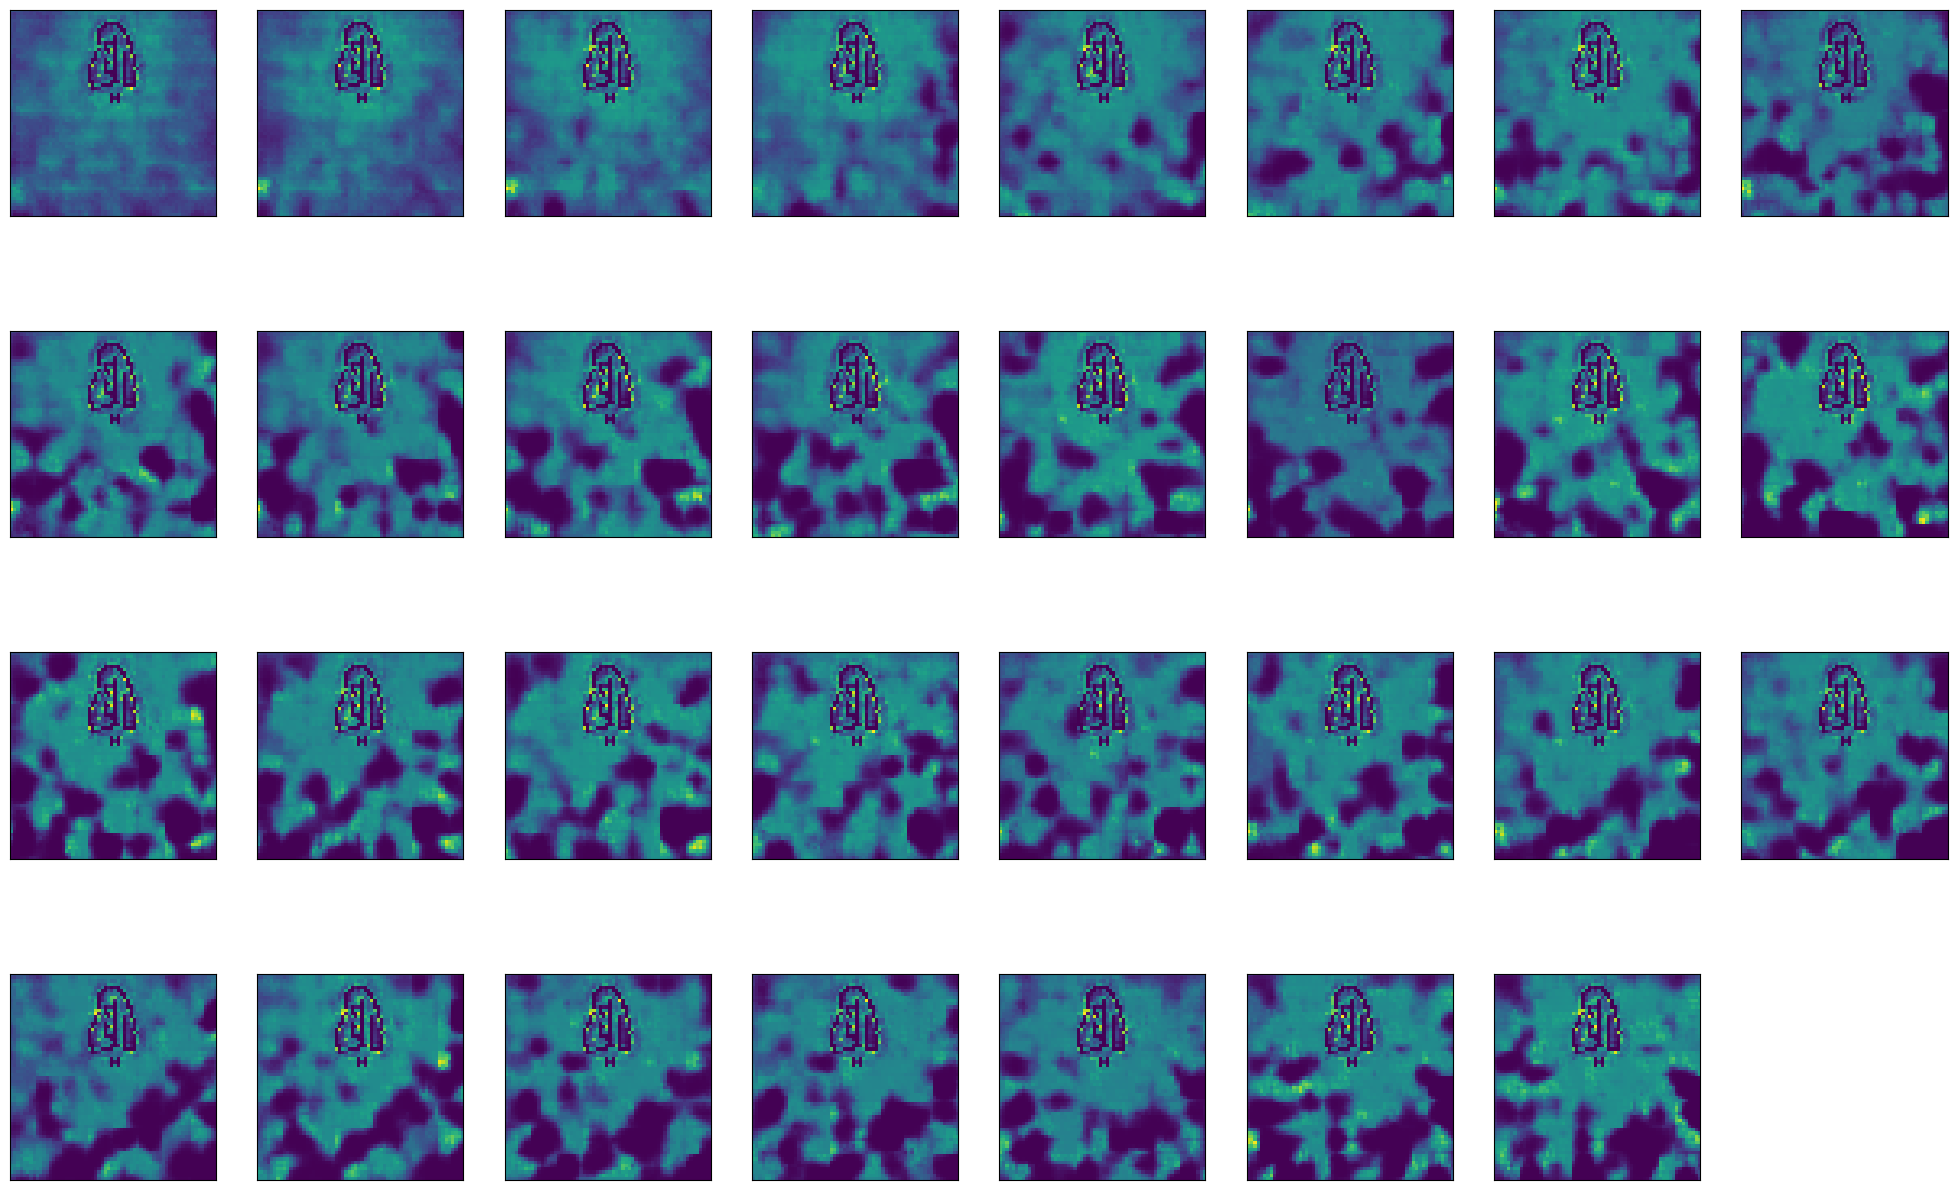

In [70]:
show_images(reconstructed_samples_full[n])

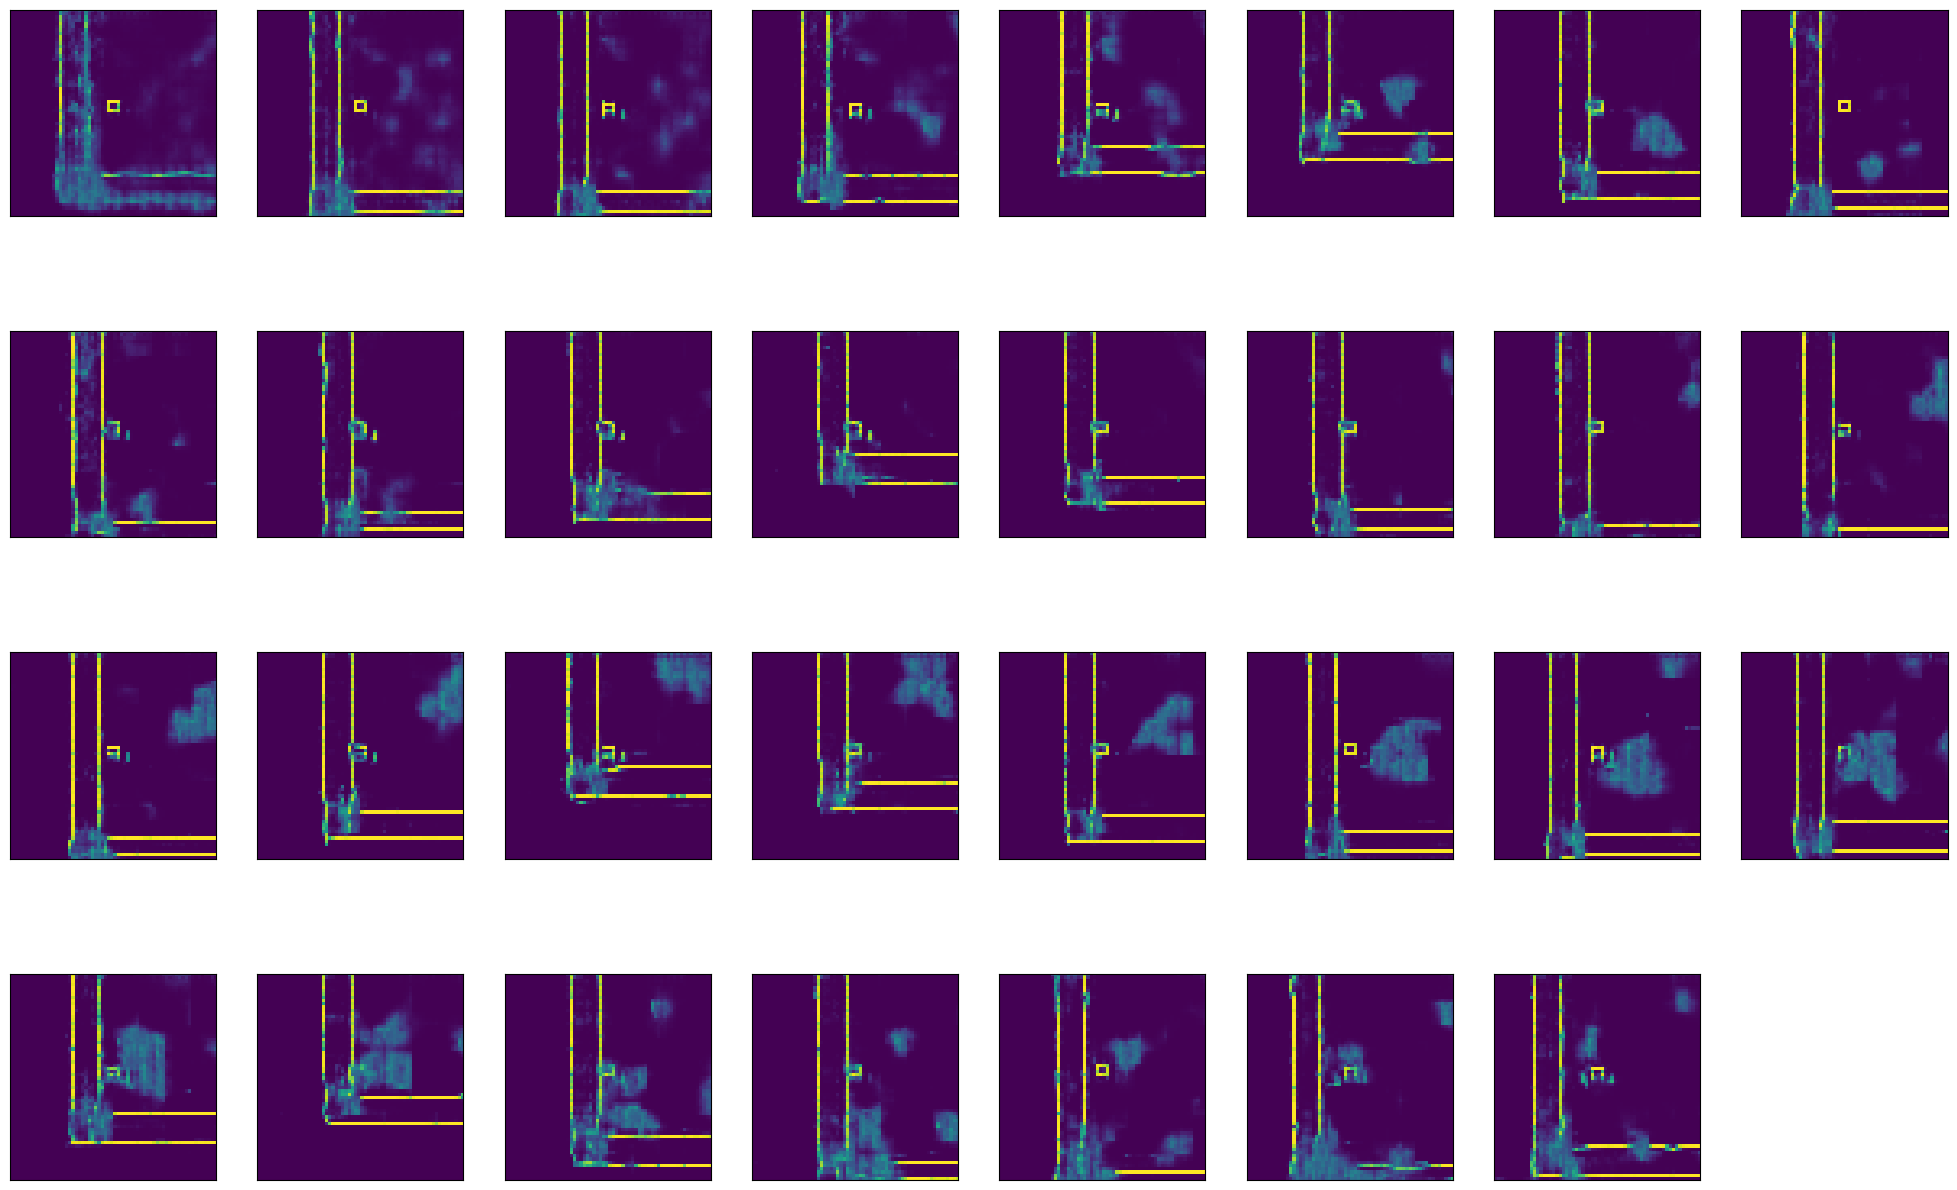

In [71]:
show_images(reconstructed_samples_part[n])

In [21]:
(decoder_debug(agent.posteriors_debug, agent.determenistics_debug).log_prob(pixel_normalization(torch.Tensor(sample)))/64/64).mean()

tensor(-46.9651, device='cuda:7', grad_fn=<MeanBackward0>)

In [27]:
obs_sample = dataset.observations[230:270,2]

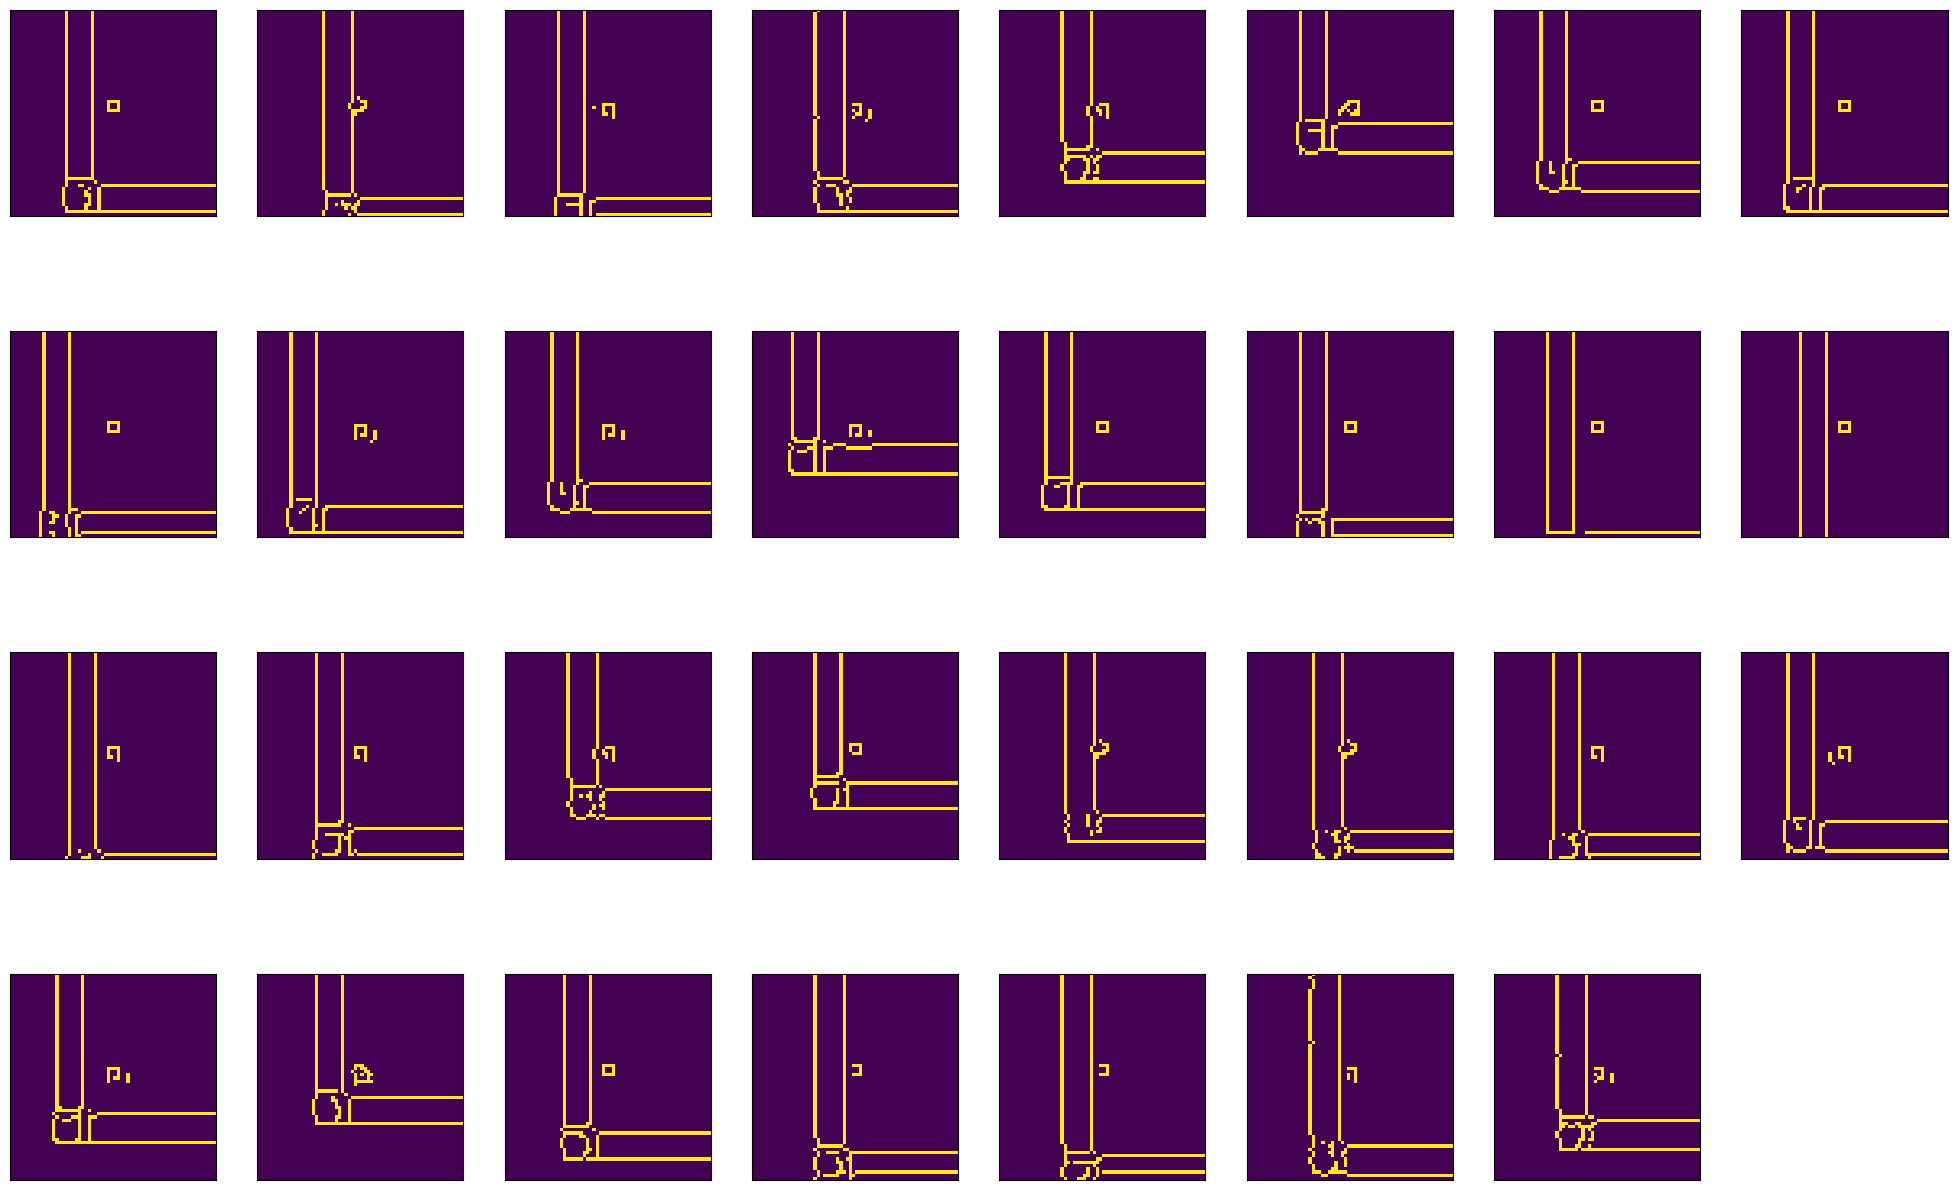

In [28]:
show_images(obs_sample)